In [2]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
stringSST = "300" ##295, 300 or 305
n_days = 25

#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

# TOOCAN objects (list d'objets MCS, leur labels et leur caractéristiques)
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [7]:
icon_seg = "/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc"
mesonh_seg = "/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc"

# Let's Big Data

In [92]:
## GPT dask fever

import dask.array as da
import dask.bag as db
import dask.dataframe as dd
import dask.distributed as ddistributed
import dask.delayed as delayed

In [93]:
chunk_size = {'time' :48, 'x' : 32, 'y' : 32}
label_chunk_size = {'time' :48, 'longitude' : 32, 'latitude' : 32}

## Open Precip data un ds

In [94]:
# Create a Dask client
client = ddistributed.Client()

# Open native precip datasets
ds1 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_1.nc", chunks = chunk_size)
ds2 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_2.nc", chunks = chunk_size)

# Combine datasets
ds = xr.concat([ds1, ds2], dim='time')
# Rename dimensions
ds["x"] = ((ds["x"])/3e3).astype(int)
ds["y"] = (ds["y"]/3e3).astype(int) 
ds["time"] = np.round(((ds["time"]-75)*48)).astype(int)
ds = ds.isel(time = slice(0, 48*n_days))

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41107 instead
  warnings.warn(


## Open MCS_list and extract the 6hours 10hours MCS annd pot some of their data distrib

In [95]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file

def idx_by_label(labels, label_list = MCS_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

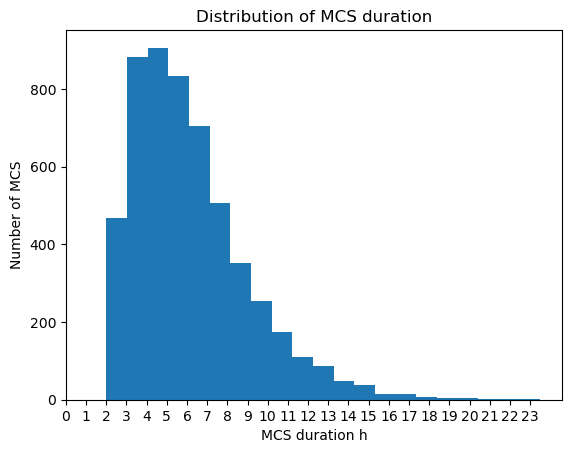

In [96]:
%matplotlib inline
MCS_durations = [MCS[i].duration for i in range(len(MCS))]
# plot the distribution of MCS duration
plt.hist([MCS[i].duration for i in range(len(MCS))], bins = (max(MCS_durations)- min(MCS_durations))//2)

#xticks are half hourly make them hourly
tick_locs = np.arange(0, max(MCS_durations), 2)
tick_labels = np.arange(0, max(MCS_durations),2)//2
plt.xticks(tick_locs, tick_labels)

plt.xlabel("MCS duration h")
plt.ylabel("Number of MCS")
plt.title("Distribution of MCS duration")
plt.show()

In [97]:
MCS_6h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in [10, 11,12,13,14]]
MCS_6h_labels = [MCS_6h[i].label for i in range(len(MCS_6h))]

MCS_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration == 20]
MCS_10h_labels = [MCS_10h[i].label for i in range(len(MCS_10h))]

## Testing

In [98]:
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg).isel(time=slice(48*n_days)).chunk(label_chunk_size)

# Put to nan the labels that are not in MCS_6h_labels
label_6h_mask = label_mask.where(label_mask.isin(MCS_6h_labels))

# mask contains the mask True or False if there is an MCS at this position over the map
mask_6h = ~label_6h_mask.where(label_6h_mask.isnull(), False).isnull()

# da contains the native precipitation values over the map filtered where there is an MCS
# Prec = ds["Prec"].where(mask_6h)

In [8]:
icon_mask = xr.open_dataarray(icon_seg)
mesonh_mask = xr.open_dataarray(mesonh_seg)

In [9]:
mesonh_mask

<xarray.DataArray 'MCS_label' (time: 1200, latitude: 128, longitude: 2000)>
[307200000 values with dtype=float64]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:           
    standard_name:  MCS_label
    long_name:      MCS labellisation

In [99]:
## TODO Vectorize with ds
time_array = np.empty_like(mask_6h, dtype=float)
age_array = np.empty_like(mask_6h, dtype=float)
time_array[:] = np.nan

for t in range(mask_6h.shape[0]):
    time_array[t][mask_6h[t]] = t
    

time_array = time_array.flatten()

In [100]:
# Define the function to map labels to MCS values and vectorize it
def Age(label, i, MCS=MCS_6h, labels=MCS_6h_labels):
    """MCS and labels must be indexed in the same fashion"""
    if ~np.isnan(label): 
        idx = labels.index(label)
        t = time_array[i]
        time_init = MCS[idx].TimeInit
        duration = MCS[idx].duration
        age = (t - time_init + 2)/duration
        if age == 0:
            print("why")
        return age if age != 0 else np.nan
    else:
        return np.nan
    
def Age_vec(label_mask):
    return np.array([Age(label, i) for i, label in enumerate(label_mask)])

# Apply the function to the label_mask
age_array = Age_vec(label_6h_mask.data.compute().flatten())

In [101]:
# Compute the distribution of native precipitation
dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 6, fill_last_decade=True)
#measure how long this line takes to run
import time
start_time = time.time()
dist_SAM_Prec.computeDistribution(sample = ds["Prec"].stack(flat=('time', 'y', 'x')))
print("--- %s seconds for computing distrib ---" % (time.time() - start_time))

--- 148.7051022052765 seconds for computing distrib ---


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [102]:
dist = dist_SAM_Prec
def computeDataOverBins(self,sample, data,sizemax=50,verbose=False,method='shuffle_mask'):
    """Find indices of bins in the sample data, to get a mapping or extremes 
    and fetch locations later
    """

    if self.bin_locations_stored and not self.overwrite:
        pass

    if verbose:
        print("Finding bin locations...")
        
    sample = sample.flatten()
    data = data.flatten()

    # Else initalize and find bin locations
    self.bin_locations = [[] for _ in range(self.nbins)]
    self.bin_sample_size = [0 for _ in range(self.nbins)]
    self.data_over_bins = [[] for _ in range(self.nbins)]
    
    if method == 'random':

        # Here, look at all points, in random order
        
        indices = list(range(self.size))
        np.random.shuffle(indices)

        bins_full = []
        for i_ind in range(len(indices)):

            i = indices[i_ind]

            # Find corresponding bin
            i_bin = self.binIndex(percentile=sample[i])

            # Store only if bin was found
            if i_bin is not None:

                # Keep count
                self.bin_sample_size[i_bin] += 1
                # Store only if there is still room in stored locations list
                if len(self.bin_locations[i_bin]) < sizemax:
                    self.bin_locations[i_bin].append(i)
                elif i_bin not in bins_full:
                    bins_full.append(i_bin)
                    bins_full.sort()
                    if verbose:
                        print("%d bins are full (%d iterations)"%(len(bins_full),i_ind))
        
    elif method == 'shuffle_mask':

        if verbose: print('bin #: ',end='')
        # compute mask for each bin, randomize and store 'sizemax' first indices
        for i_bin in range(self.nbins):

            if verbose: print('%d..'%i_bin,end='')
            
            mask = np.logical_and(sample.flatten() >= self.bins[i_bin], sample.flatten() < self.bins[i_bin+1])
            
            # get all indices
            ind_mask = np.where(mask)[0]
            # shuffle
            np.random.seed(int(round(time.time() * 1000)) % 1000)
            np.random.shuffle(ind_mask)

            self.bin_sample_size[i_bin] = ind_mask.size # count all points there
            # select 'sizemax' first elements
            self.bin_locations[i_bin] = ind_mask[:sizemax]
            # store data
            data_nan = data[ind_mask[:]]
            data_no_nan = data_nan[~np.isnan(data_nan)]
            self.data_over_bins[i_bin]  = data_no_nan

        if verbose: print()

    if verbose:
        print()

    # If reach this point, everything should have worked smoothly, so:
    self.bin_locations_stored = True
    return(self.data_over_bins)

In [103]:
import time

start_time = time.time()
Age_Over_bins = computeDataOverBins(dist_SAM_Prec, sample = ds["Prec"].values, data= age_array, sizemax = 100000)
print("--- %s seconds for storing sample points ---" % (time.time() - start_time))

--- 74.52199268341064 seconds for storing sample points ---


In [106]:
%matplotlib inline
nrows = 1
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Age_Over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks")

ax.set_ylabel("Relative Age of precipitation under MCS")
plt.legend()
plt.title("Relative Age of MCS of about 6h duration")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
